In [1]:
import morphine
import webbpsf
import poppy # need development version to work with synphot and webbpsf
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams["font.family"] = "Times New Roman"
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline

In [2]:
niriss = webbpsf.NIRISS()
niriss.filter = "F380M"
niriss.pupil_mask = "MASK_NRM"

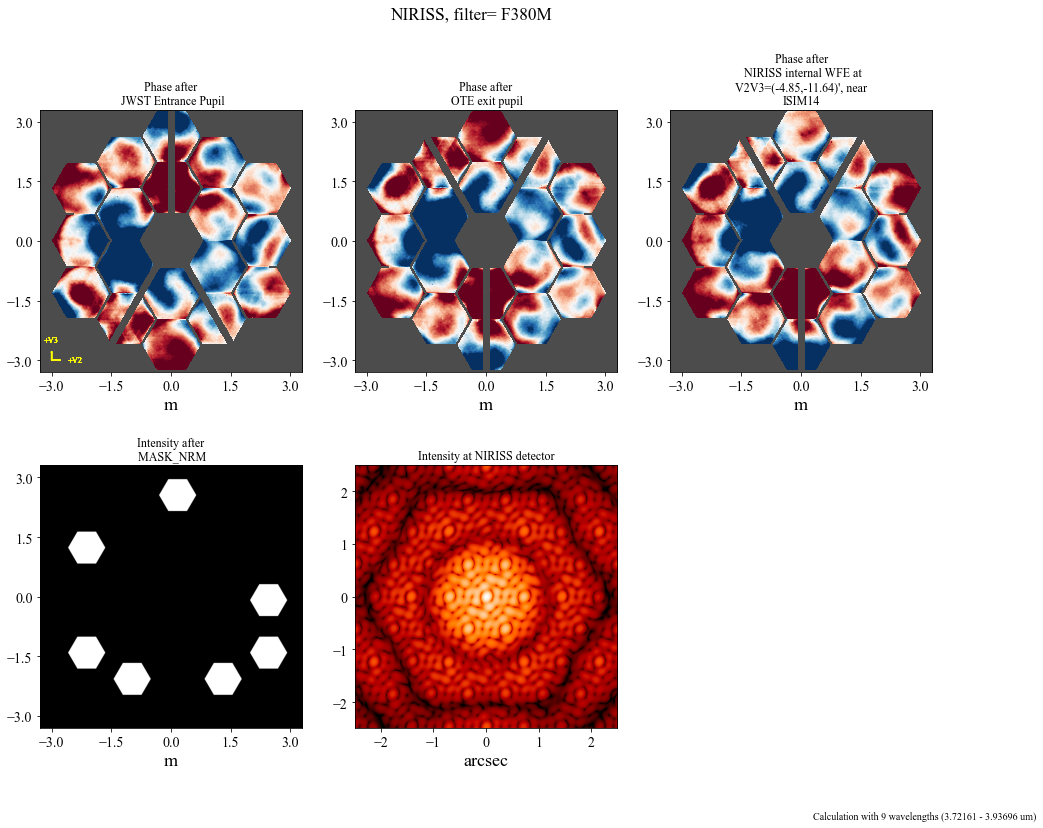

In [3]:
plt.figure(figsize=(16, 12))
psf = niriss.calc_psf(display=True)

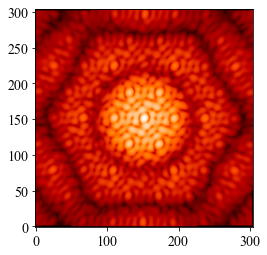

In [4]:
plt.imshow(np.log(psf[-2].data + 1e-10), cmap="gist_heat", origin="lower")
# psf[0].header

In [5]:
optsys = niriss.get_optical_system(fft_oversample=4, fov_arcsec=5)

<AxesSubplot:title={'center':'Intensity at NIRISS detector'}, xlabel='arcsec'>

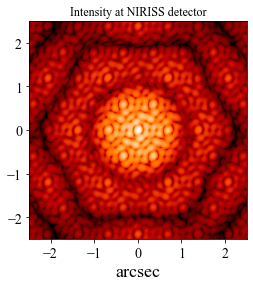

In [6]:
webbpsf_out, webbpsf_intermediates = optsys.propagate(optsys.input_wavefront(3.8e-6), return_intermediates=True)
webbpsf_out.display()

In [7]:
morphine_niriss = morphine.OpticalSystem(name="ami_niriss")

pupil_shift = np.array([0.0243,  -0.0141])  # CV3 on-orbit estimate (RPT028027) + OTIS delta from predicted (037134)

# entrance pupil
morphine_niriss.add_pupil(morphine.ArrayOpticalElement(
    transmission=optsys.planes[0].amplitude,
    opd=optsys.planes[0].opd,
    pixelscale=optsys.planes[0].pixelscale,
    name=optsys.planes[0].name,
    oversample=optsys.planes[0].oversample,
))

morphine_niriss.add_inversion(index=1, axis="y", name=optsys.planes[1].name)

# JWST internal WFE error
morphine_niriss.add_pupil(morphine.ArrayOpticalElement(
    transmission=optsys.planes[2].amplitude,
    opd=optsys.planes[2].opd,
    pixelscale=optsys.planes[2].pixelscale,
    name=optsys.planes[2].name,
    oversample=optsys.planes[2].oversample
))
# NRM
morphine_niriss.add_pupil(morphine.ArrayOpticalElement(
    transmission=optsys.planes[3].amplitude,
    opd=optsys.planes[3].opd,
    pixelscale=optsys.planes[3].pixelscale,
    name=optsys.planes[3].name,
    oversample=optsys.planes[3].oversample
))

morphine_niriss.add_detector(
    pixelscale=optsys.planes[-1].pixelscale.value, # does not support astropy units
    fov_arcsec=optsys.planes[-1].fov_arcsec.value,
    oversample=optsys.planes[-1].oversample,
    name=optsys.planes[-1].name
);

/home/alexandre/anaconda3/envs/exorim/lib/python3.8/site-packages/jax-0.1.77-py3.8.egg/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [8]:
morphine_niriss.describe()

	Pupil plane: JWST Entrance Pupil 
	Coordinate Inversion in y axis
	Pupil plane: NIRISS internal WFE at V2V3=(-4.85,-11.64)', near ISIM14 
	Pupil plane: MASK_NRM 
	Detector plane: NIRISS detector (76x76 pixels, 0.066)


In [9]:
optsys.describe()

	Pupil plane: JWST Entrance Pupil 
	Coordinate Inversion in y axis
	Pupil plane: NIRISS internal WFE at V2V3=(-4.85,-11.64)', near ISIM14 
	Pupil plane: MASK_NRM 
	Detector plane: NIRISS detector (76x76 pixels, 0.066 arcsec / pix)


In [10]:
morphine_out, morphine_intermediates = morphine_niriss.propagate(morphine_niriss.input_wavefront(3.8e-6), return_intermediates=True)

/home/alexandre/anaconda3/envs/exorim/lib/python3.8/site-packages/jax-0.1.77-py3.8.egg/jax/lax/lax.py:6198: UserWarning: Explicitly requested dtype <class 'numpy.complex128'> requested in ones is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


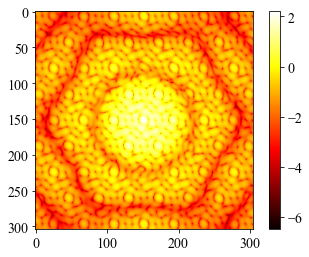

In [11]:
plt.imshow(np.log10(morphine_out.intensity), cmap="hot")
plt.colorbar()

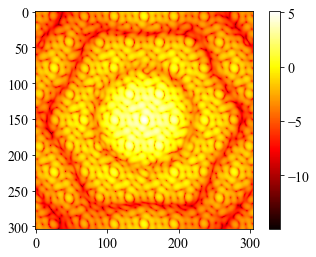

In [12]:
plt.imshow(np.log(webbpsf_out.intensity), cmap="hot")
plt.colorbar()

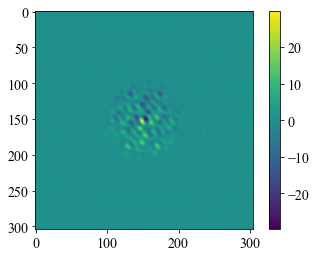

In [13]:
plt.imshow(morphine_out.intensity - webbpsf_out.intensity)
plt.colorbar()

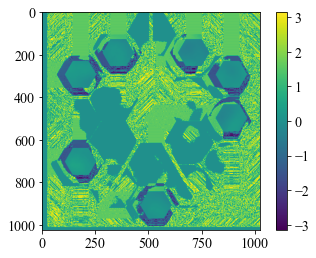

In [14]:
plt.imshow(morphine_intermediates[3].phase)
plt.colorbar()

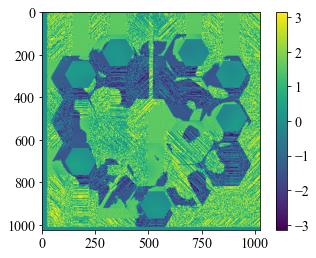

In [15]:
plt.imshow(webbpsf_intermediates[3].phase)
plt.colorbar()

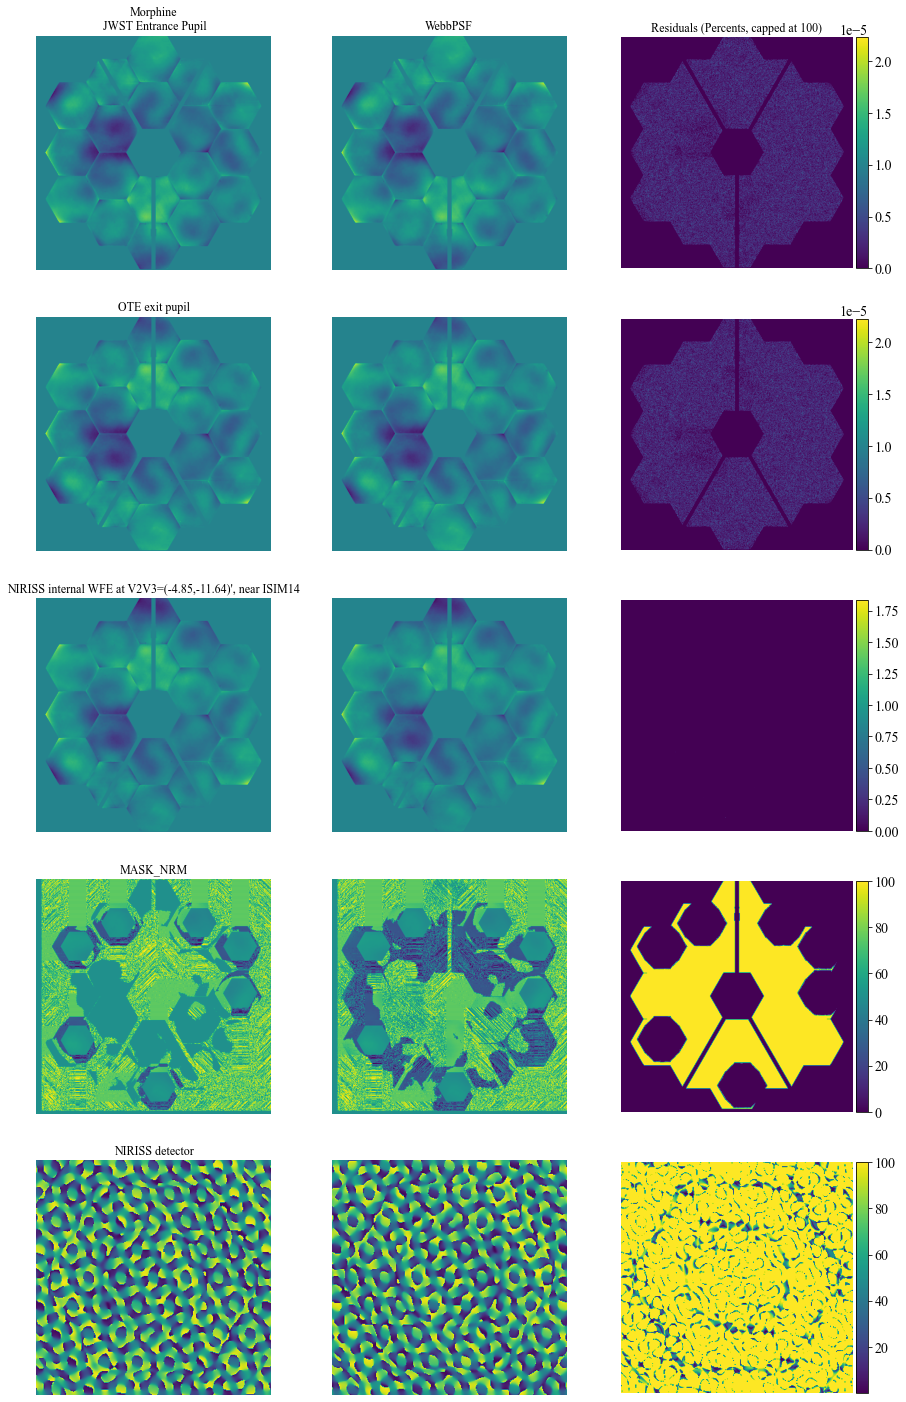

In [16]:
fig, axs = plt.subplots(5, 3, figsize=(15, 25))
x = [morphine_intermediates[i].phase for i in range(5)]
y = [webbpsf_intermediates[i].phase for i in range(5)]
residuals = [np.minimum(np.abs((x[i] - y[i])/(np.abs(y[i])+1e-16))*100, np.ones_like(x[i])*100) for i in range(5)]
titles = ["Morphine", "WebbPSF", "Residuals (Percents, capped at 100)"]
images = [x, y, residuals]
for i in range(5):
    for j in range(3):
        im = axs[i, j].imshow(images[j][i])
        axs[i, j].axis("off")
        if i == 0:
            if j == 0:
                axs[i, j].set_title(f"{titles[j]}\n {morphine_niriss.planes[i].name}")
            else:
                axs[i, j].set_title(f"{titles[j]}")
        elif j == 0:
            axs[i, j].set_title(f"{morphine_niriss.planes[i].name}")
        if j == 2:
            divider = make_axes_locatable(axs[i, j])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical')
plt.savefig("morphine_webbpsf_phase_comparison.png")

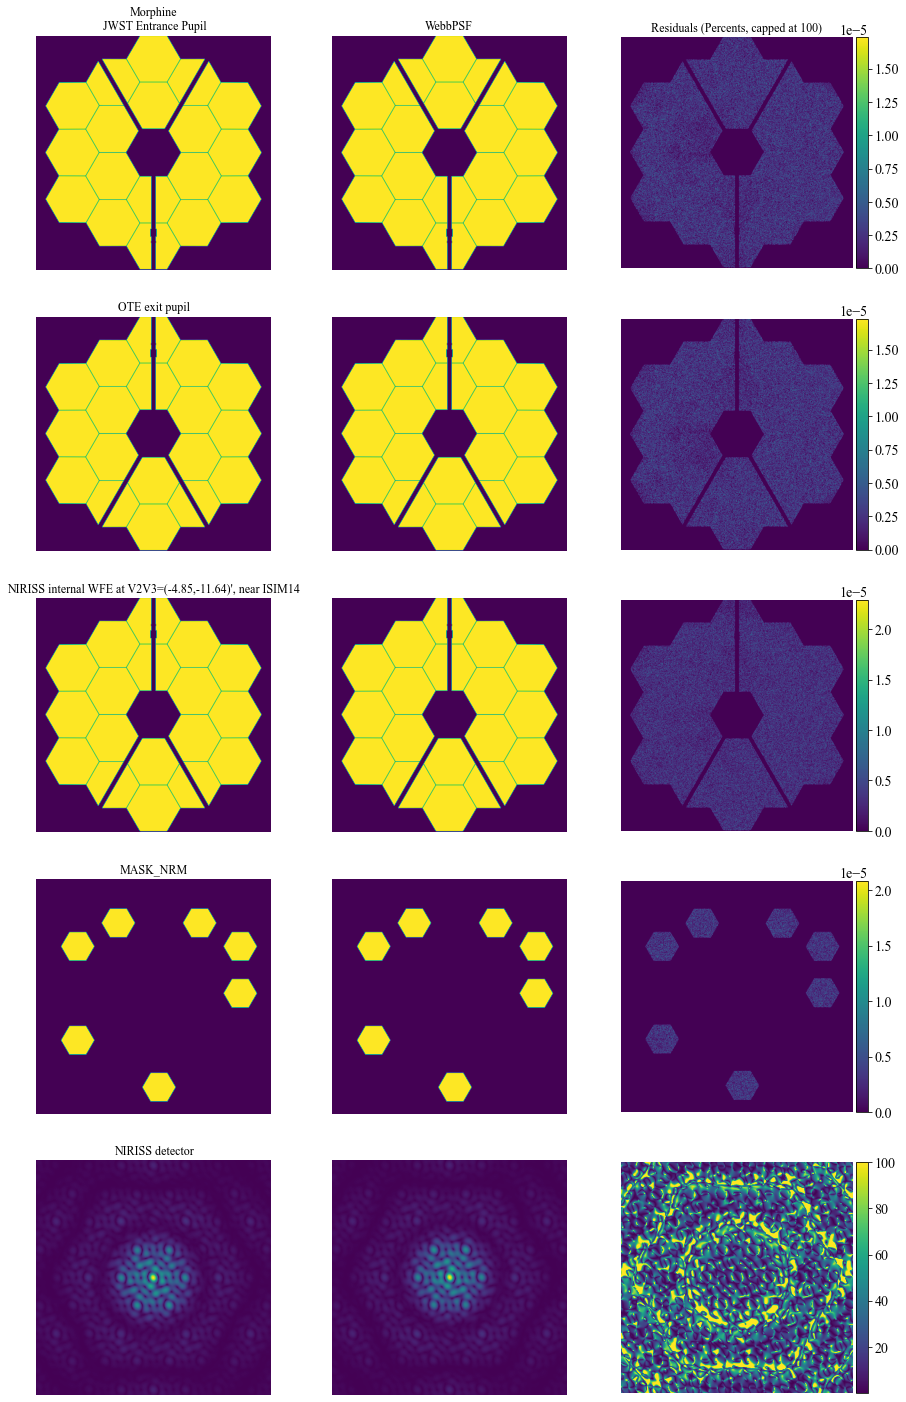

In [17]:
fig, axs = plt.subplots(5, 3, figsize=(15, 25))
x = [morphine_intermediates[i].amplitude for i in range(5)]
y = [webbpsf_intermediates[i].amplitude for i in range(5)]
residuals = [np.minimum(np.abs(x[i] - y[i])/(y[i]+1e-16)*100, np.ones_like(x[i])*100) for i in range(5)]
titles = ["Morphine", "WebbPSF", "Residuals (Percents, capped at 100)"]
images = [x, y, residuals]
for i in range(5):
    for j in range(3):
        im = axs[i, j].imshow(images[j][i])
        axs[i, j].axis("off")
        if i == 0:
            if j == 0:
                axs[i, j].set_title(f"{titles[j]}\n {morphine_niriss.planes[i].name}")
            else:
                axs[i, j].set_title(f"{titles[j]}")
        elif j == 0:
            axs[i, j].set_title(f"{morphine_niriss.planes[i].name}")
        if j == 2:
            divider = make_axes_locatable(axs[i, j])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical')
plt.savefig("morphine_webbpsf_amplitude_comparison.png")

In [18]:
morphine_niriss.source_offset_theta

0

In [19]:
pixelscale=optsys.planes[-1].pixelscale.value

In [20]:
pixelscale

0.0656

In [21]:
fov=optsys.planes[-1].fov_arcsec.value

In [22]:
fov

4.985600000000001

In [23]:
fov/pixelscale * 3

228.0

In [24]:
wavelength = 3.8e-6

In [25]:
from scipy.signal import hamming

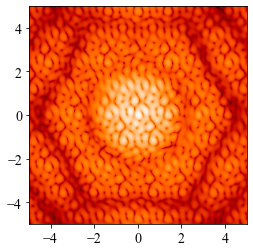

In [26]:
xmin = ymin = -fov
xmax = ymax = -xmin
wave1 = optsys.input_wavefront(3.8e-6) # binary system of unresolved stars
wave2 = optsys.input_wavefront(3.8e-6)
amp2 = 0.5
wave2.tilt(0.2)
wave2.rotate(90)
out1, _ = optsys.propagate(wave1, return_intermediates=True)
out2, _ = optsys.propagate(wave2, return_intermediates=True)
out = out1 + out2 * amp2
vmax = np.log(out.intensity).max()
vmin = np.log(out.intensity).min()
plt.imshow(np.log(out.intensity), extent=[xmin, xmax, ymin, ymax], cmap="gist_heat", vmax=vmax, vmin=vmin)

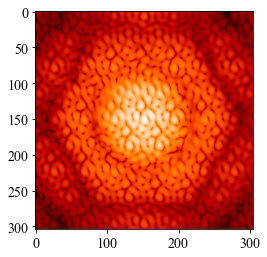

In [27]:
h = hamming(out.intensity.shape[0])
h = np.outer(h, h)
out_windowed = out.intensity * h
plt.imshow(np.log(out_windowed), cmap="gist_heat", vmax=vmax, vmin=vmin)

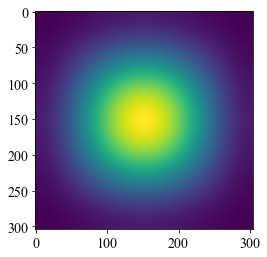

In [28]:
plt.imshow(h)

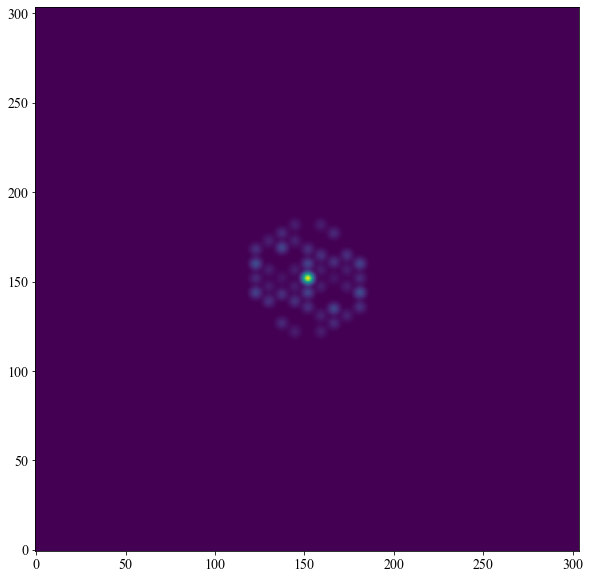

In [247]:
plt.figure(figsize=(10, 10))
# fft = np.fft.fftshift(np.fft.ifft2(out.intensity))
fft = np.fft.fftshift(np.fft.fft2(out_windowed))
plt.imshow(np.abs(fft), origin="lower")

In [33]:
from exorim.interferometry.operators import Baselines
mask_coordinates = np.array([ #V2/mm and V3/mm coordinates
    [1143, 1980],   # C1
    [2282, 1317],   # B2
    [2286, 0],      # C2
    [0, -2635],     # B4
    [-2282, -1317], # B5
    [-2282, 1317],  # B6
    [-1143, 1980]   # C6
])
mask_coordinates = mask_coordinates / 1000 # meters

B = Baselines(mask_coordinates)
uv = B.UVC
uv= np.concatenate([uv, -uv]) # add hermitian part
uv /= wavelength

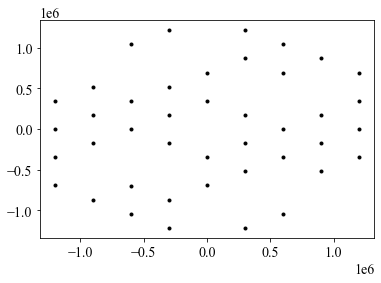

In [34]:
plt.plot(uv[:, 0], uv[:, 1], "k.")

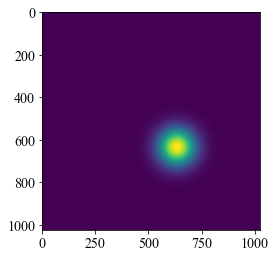

In [345]:
# now consider a more complex image, then transform it into a wavefront (ie take its Fourier Transform!)
instrument = webbpsf.NIRISS()
instrument.filter = "CLEAR"
instrument.pupil_mask = "CLEARP"
optsys_test = instrument.get_optical_system(fft_oversample=4, fov_arcsec=2)
import astropy.units as u
image_wave = optsys_test.input_wavefront(3.8e-6)
image = np.zeros(image_wave.shape)
coords = image_wave.image_coordinates(shape=image_wave.shape, pixelscale=wave1.pixelscale, last_transform_type="fft", image_centered=True) # arcsec coords
xx, yy = coords
rho = np.hypot(xx-2, yy-2)
image += np.exp(-0.5 * rho**2 / 1**2)
plt.imshow(image)

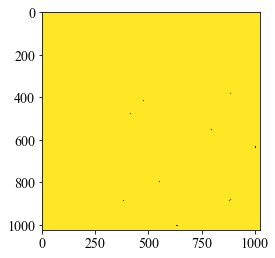

In [346]:

fft_phase = np.angle(np.fft.fftshift(np.fft.fft2(image)) * np.exp(1j * (2 * np.pi / image_wave.wavelength * wave1.pixelscale.to(u.rad / u.pix) * image_wave.shape[0] * u.pix).value))
# image_wave.wavefront *= np.exp(1j * fft_phase)
# image_wave.wavefront *= np.fft.fftshift(np.fft.fft2(image)) * np.exp(1j * (2 * np.pi / image_wave.wavelength * wave1.pixelscale.to(u.rad / u.pix) * image_wave.shape[0] * u.pix).value)
input_wavefront = image_wave.wavefront.copy()
plt.imshow(np.abs(image_wave.wavefront))

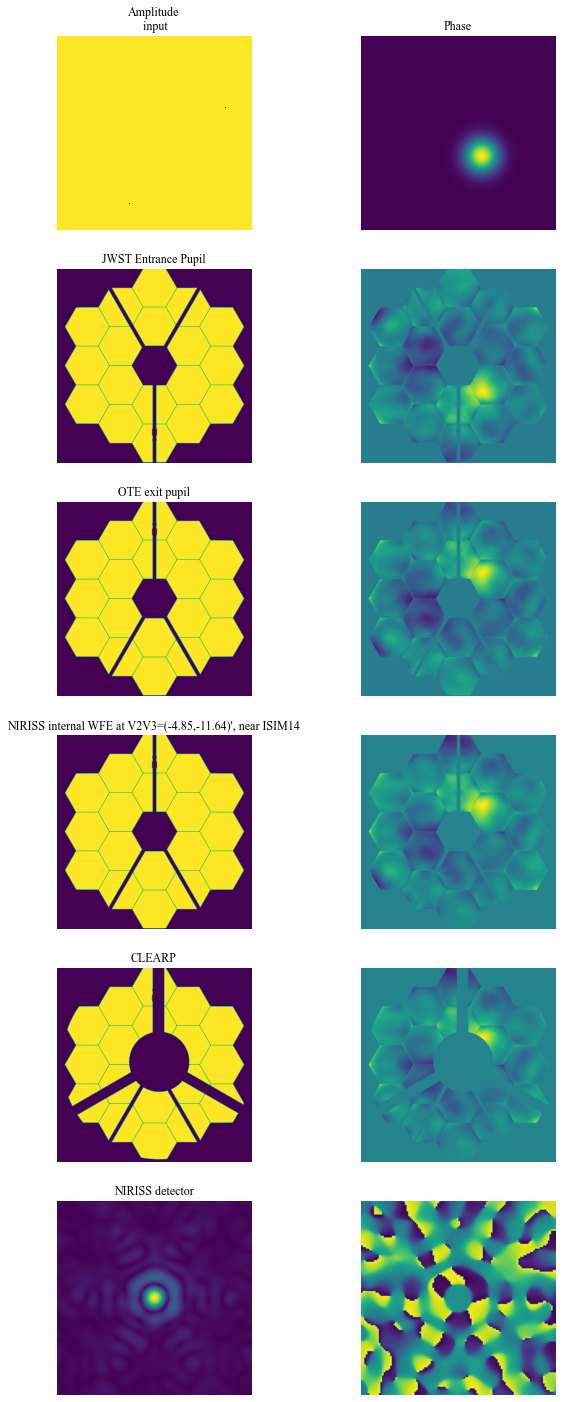

In [347]:
image_out, image_intermediates = optsys_test.propagate(image_wave, return_intermediates=True)
fig, axs = plt.subplots(6, 2, figsize=(10, 25))
x = [np.abs(input_wavefront)]
x += [image_intermediates[i].amplitude for i in range(5)]
y = [np.angle(input_wavefront)]
y += [image_intermediates[i].phase for i in range(5)]
titles = ["Amplitude", "Phase"]
images = [x, y]
for i in range(6):
    for j in range(2):
        im = axs[i, j].imshow(images[j][i])
        axs[i, j].axis("off")
        if i == 0:
            if j == 0:
                axs[i, j].set_title(f"{titles[j]}\n input")
            else:
                axs[i, j].set_title(f"{titles[j]}")
        elif j == 0:
                axs[i, j].set_title(f"{optsys_test.planes[i-1].name}")

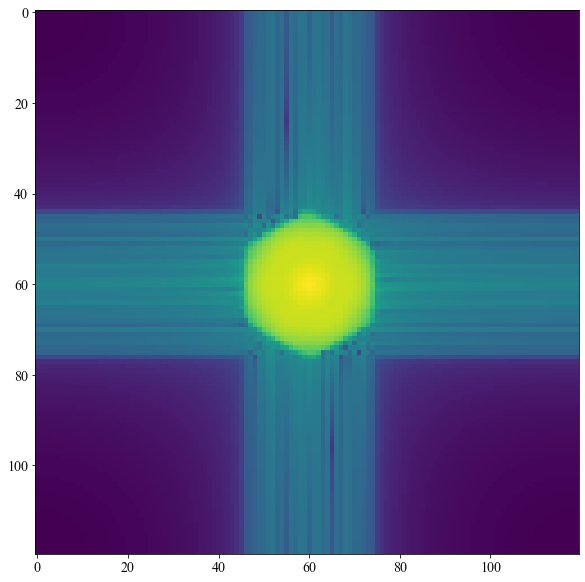

In [348]:
plt.figure(figsize=(10, 10))
fft_detector = np.fft.fftshift(np.fft.fft2(image_out.intensity))
plt.imshow(np.log(np.abs(fft_detector)))